# Simple Address Matching with Libpostal

This notebook implements a simple address matcher using Libpostal address parsing and field-level equality.

In [5]:
import json
import logging
import os
import random
import re
import sys
import time
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytest
import random
import seaborn as sns
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from tqdm import tqdm

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    format_dataset,
    gold_label_report,
    preprocess_logits_for_metrics,
    structured_encode_address,
    tokenize_function,
    to_dict,
    save_transformer,
    load_transformer,
)

#### Pin Random Seeds for Reproducibility

In [6]:
RANDOM_SEED = 31337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

#### Setup Basic Logging

In [7]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Configure Pandas to Show More Rows

In [8]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

## Implementing a Simple, Structured Address Matcher

Let's start our exercise by using the structured address data provided by [Libpostal](https://github.com/openvenues/libpostal) to parse them for matching. We write a function for each address part to deal with missing fields without duplicating a lot of logic.

We start with something quite literal and basic. We'll improve it as we go.

In [9]:
def parse_match_address(address1: str, address2: str) -> Literal[0, 1]:
    """parse_match_address implements address matching using the precise, parsed structure of addresses."""
    address1 = to_dict(parse_address(address1))
    address2 = to_dict(parse_address(address2))

    def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_road - literal road matching, negative if either lacks a road"""
        if ("road" in address1) and ("road" in address2):
            if address1["road"] == address2["road"]:
                logger.debug("road match")
                return 1
            else:
                logger.debug("road mismatch")
                return 0
        logger.debug("road mismatch")
        return 0

    def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_house_number - literal house number matching, negative if either lacks a house_number"""
        if ("house_number" in address1) and ("house_number" in address2):
            if address1["house_number"] == address2["house_number"]:
                logger.debug("house_number match")
                return 1
            else:
                logger.debug("house_number mismatch")
                return 0
        logger.debug("house_number mistmatch")
        return 0

    def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_unit - note a missing unit in both is a match"""
        if "unit" in address1:
            if "unit" in address2:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        if "unit" in address2:
            if "unit" in address1:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        # Neither address has a unit, which is a default match
        return 1

    def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_postcode - literal matching, negative if either lacks a postal code"""
        if ("postcode" in address1) and ("postcode" in address2):
            if address1["postcode"] == address2["postcode"]:
                logger.debug("postcode match")
                return 1
            else:
                logger.debug("postcode mismatch")
                return 0
        logger.debug("postcode mismatch")
        return 0

    def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_country - literal country matching - pass if both don't have one"""
        if ("country" in address1) and ("country" in address2):
            if address1["country"] == address2["country"]:
                logger.debug("country match")
                return 1
            else:
                logger.debug("country mismatch")
                return 0
        # One or none countries should match
        logger.debug("country match")
        return 1

    # Combine the above to get a complete address matcher
    if (
        match_road(address1, address2)
        and match_house_number(address1, address2)
        and match_unit(address1, address2)
        and match_postcode(address1, address2)
        and match_country(address1, address2)
    ):
        logger.debug("overall match")
        return 1
    else:
        logger.debug("overall mismatch")
        return 0

In [10]:
# Yup down to house_number ...
parse_match_address(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

1

In [11]:
fuzz.ratio(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

97

In [12]:
# Yup down to unit ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

1

In [13]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

94

In [14]:
# Nope if only one uses an abbreviation ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

0

In [15]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

95

In [16]:
# Nope if one character in the streetname is off ...
parse_match_address(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

0

In [17]:
fuzz.ratio(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

99

### Literal is Too Precise!

While it is useful to parse addresses and implement literal matching logic as we did above, as the third example indicates, an abbreviation or a single typo results in a mistmatch. We're going to write a more complex, approximate logical matcher below using string distance and text embeddings.

Depending on your application you might relax this criteria to include corner cases such as missing postcodes. Before we get into that, let's create some training and evaluation data using hand-labeled data with an LLM data augmentation strategy to generate a lot of labeled records.

## Data Augmentation with the OpenAI GPT4o API

We need training data for our supervised learning approaches to addres matching. Open the sister notebook [Address Data Augmentation.ipynb](Address%20Matching%20Deep%20Dive.ipynb) before procceeding to further cells in order to create some training data via minimal manual labeling and programmatic data labeling for data augmentation. This will teach you programmatic data labeling, a critical skill that LLMs make MUCH EASIER because they understand things like the semantics of global addresses.

In [25]:
gold_df = pd.read_csv("data/gold.csv")

In [19]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.6.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm St, Boston, MA 02118","456 West Elm Street, Boston, Massachusetts 02118",Different directional prefix formats for same ...,1.0
2,"789 S Oak St, Denver, CO 80203","789 South Oak Street, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
3,"321 N Pine St, Seattle, WA 98101","321 North Pine Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
4,"654 E Maple St, Austin, TX 73301","654 East Maple Street, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
5,"987 W Cedar St, San Francisco, CA 94102","987 West Cedar Street, San Francisco, Californ...",Different directional prefix formats for same ...,1.0
6,"246 S Birch St, New York, NY 10001","246 South Birch Street, New York, New York 10001",Different directional prefix formats for same ...,1.0
7,"135 N Cedar Ave, Chicago, IL 60601","135 North Cedar Avenue, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
8,"864 E Pine Ave, Los Angeles, CA 90001","864 East Pine Avenue, Los Angeles, California ...",Different directional prefix formats for same ...,1.0
9,"753 W Spruce St, Houston, TX 77001","753 West Spruce Street, Houston, Texas 77001",Different directional prefix formats for same ...,1.0


### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

### Gold Label Evaluation

In [26]:
def match_address_series(row: pd.Series):
    return parse_match_address(row["Address1"], row["Address2"])

In [27]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(match_address_series, axis=1)

In [28]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

Best Threshold: 0
Best F1 Score: 0.6942148760330579
AUC-ROC: 0.6428571428571428


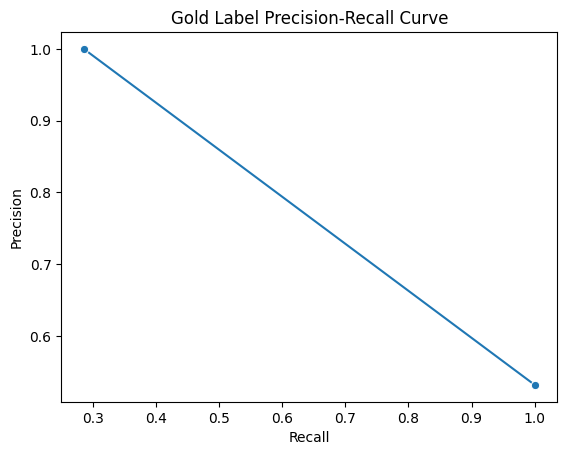

In [29]:
# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

In [30]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        match_address_series,
    ],
    threshold=best_threshold
)

In [37]:
grouped_df.sort_values(by="match_address_series_acc", ascending=False).head()

,match_address_series_acc
Description,
Including and excluding building names for same address should match,1.0
Typographical errors in same address with country should match,1.0
Same address with and without country should match,1.0
Floor bumbers included or excluded for same address should match,1.0
Typographical errors in city of same address should match,1.0


In [38]:
# Truthiness analysis
correct_df = raw_df[raw_df["match_address_series_correct"]].reset_index(drop=True)
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 49


,Description,Address1,Address2,Label,match_address_series,match_address_series_correct
0,Missing state but has postal code and country ...,"Pariser Platz 2, 10117 Berlin, Germany","Pariser Platz 2, 10117 Berlin, Berlin, Germany",1,1,True
1,Missing state but has postal code and country ...,"Marienplatz 1, 80331 Munich, Germany","Marienplatz 1, 80331 Munich, Bavaria, Germany",1,1,True
2,Same address with and without country should m...,"1600 Amphitheatre Parkway, Mountain View, CA 9...","1600 Amphitheatre Parkway, Mountain View, CA 9...",1,1,True
3,Same address with and without country should m...,"3413 Sean Way, Lawrenceville, GA 30044, U.S.A.","3413 Sean Way, Lawrenceville, Georgia, 30044",1,1,True
4,Including and excluding building names for sam...,"The Empire State Building, 350 5th Ave, New Yo...","350 5th Ave, New York, NY 10118",1,1,True
5,Floor bumbers included or excluded for same ad...,"350 5th Ave, 86th Floor, New York, NY 10118","350 5th Ave, New York, NY 10118",1,1,True
6,Same address incorporates business name or not...,"Google, 1600 Amphitheatre Parkway, Mountain Vi...","1600 Amphitheatre Parkway, Mountain View, CA 9...",1,1,True
7,Typographical errors in same address with coun...,"Calle Mayor, 10, 28013 Madrid, España","Calle Mayor, 10, 28013 Madird, España",1,1,True
8,Typographical errors in city of same address s...,"16 Rue de la Paix, 75002 Paris, France","16 Rue de la Paix, 75002 Pariss, France",1,1,True
9,Typographical errors in city of same address s...,"Alexanderplatz 1, 10178 Berlin, Deutschland","Alexanderplatz 1, 10178 Berin, Deutschland",1,1,True


In [39]:
# Error analysis
wrong_df = raw_df[raw_df["match_address_series_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 30


,index,Description,Address1,Address2,Label,match_address_series,match_address_series_correct
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,0,False
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,0,False
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,0,False
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,0,False
4,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False
5,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,0,False
6,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,0,False
7,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,0,False
8,8,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False
9,9,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,0,False


In [40]:
parse_match_address(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0

In [41]:
parse_match_address(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0

In [42]:
parse_match_address(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0

In [43]:
parse_match_address(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0

In [44]:
parse_match_address(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

1